# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support

/var/folders/5n/5nt9ztr10sx56m052vljdpfw0000gn/T/ipykernel_72887/3502098173.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
training = pd.read_csv('./UNSW_NB15_training-set.csv')
testing = pd.read_csv('./UNSW_NB15_testing-set.csv')

df = pd.concat([training, testing])

In [3]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


# Pre-Processing

In [4]:
drop_cols = ['id', 'label']
df.drop(drop_cols,axis=1,inplace=True)

In [5]:
df.columns.tolist()

['dur',
 'proto',
 'service',
 'state',
 'spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'sloss',
 'dloss',
 'sinpkt',
 'dinpkt',
 'sjit',
 'djit',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'tcprtt',
 'synack',
 'ackdat',
 'smean',
 'dmean',
 'trans_depth',
 'response_body_len',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_flw_http_mthd',
 'ct_src_ltm',
 'ct_srv_dst',
 'is_sm_ips_ports',
 'attack_cat']

### Apply Clamping

The extreme values should be pruned to reduce the skewness of some distributions. The logic applied here is that the features with a maximum value more than ten times the median value is pruned to the 95th percentile. If the 95th percentile is close to the maximum, then the tail has more interesting information than what we want to discard.

The clamping is also only applied to features with a maximum of more than 10 times the median. This prevents the bimodals and small value distributions from being excessively pruned.

In [6]:
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.describe(include='all')

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
count,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,6.582143e+05,...,6.050467,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274
std,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,2.412372e+06,...,8.173749,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,0.000000e+00,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000
50%,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,1.747441e+03,...,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000
75%,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,2.210538e+04,...,6.000000,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,...,59.000000,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000


In [7]:
DEBUG =0

for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('max = '+str(df_numeric[feature].max()))
        print('75th = '+str(df_numeric[feature].quantile(0.95)))
        print('median = '+str(df_numeric[feature].median()))
        print(df_numeric[feature].max()>10*df_numeric[feature].median())
        print('----------------------------------------------------')
    if df_numeric[feature].max()>10*df_numeric[feature].median() and df_numeric[feature].max()>10 :
        df[feature] = np.where(df[feature]<df[feature].quantile(0.95), df[feature], df[feature].quantile(0.95))

## Apply log function to nearly all numeric, since they are all mostly skewed to the right

The extreme values should be pruned to reduce the skewness of some distributions. The logic applied here is that the features with a maximum value more than ten times the median value is pruned to the 95th percentile. If the 95th percentile is close to the maximum, then the tail has more interesting information than what we want to discard.

The clamping is also only applied to features with a maximum of more than 10 times the median. This prevents the bimodals and small value distributions from being excessively pruned.

In [8]:
df_numeric = df.select_dtypes(include=[np.number])
df_before = df_numeric.copy()
DEBUG = 0
for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_numeric[feature].nunique()))
        print(df_numeric[feature].nunique()>50)
        print('----------------------------------------------------')
    if df_numeric[feature].nunique()>50:
        if df_numeric[feature].min()==0:
            df[feature] = np.log(df[feature]+1)
        else:
            df[feature] = np.log(df[feature])

df_numeric = df.select_dtypes(include=[np.number])

## Reduce the labels in categorical features

In [9]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state,attack_cat
count,257673,257673,257673,257673
unique,133,13,11,10
top,tcp,-,FIN,Normal
freq,123041,141321,117164,93000


In [10]:
DEBUG = 0
for feature in df_cat.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_cat[feature].nunique()))
        print(df_cat[feature].nunique()>11)
        print(sum(df[feature].isin(df[feature].value_counts().head().index)))
        print('----------------------------------------------------')
    
    if df_cat[feature].nunique()>11:
        df[feature] = np.where(df[feature].isin(df[feature].value_counts().head().index), df[feature], '-')

In [11]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state,attack_cat
count,257673,257673,257673,257673
unique,6,5,11,10
top,tcp,-,FIN,Normal
freq,123041,149701,117164,93000


In [12]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2,k='all')

X = df.iloc[:,4:-2]
y = df.iloc[:,-1]
fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Top 20 Features",
                  height=1200,
                  showlegend=False,
                 )

fig.show()

## Encode categorical features

The categorical features must be encoded to ensure that the models can interpret them. One-hot encoding is used since none of the categorical features are ordinal.

In [13]:
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.000011,udp,-,INT,0.693147,0.000000,6.206576,0.000000,11.417626,254,...,1.0,1.0,2.0,0,0,0.0,1.0,2.0,0,Normal
1,0.000008,udp,-,INT,0.693147,0.000000,7.474205,0.000000,11.736077,254,...,1.0,1.0,2.0,0,0,0.0,1.0,2.0,0,Normal
2,0.000005,udp,-,INT,0.693147,0.000000,6.973543,0.000000,12.206078,254,...,1.0,1.0,3.0,0,0,0.0,1.0,3.0,0,Normal
3,0.000006,udp,-,INT,0.693147,0.000000,6.802395,0.000000,12.023757,254,...,2.0,1.0,3.0,0,0,0.0,2.0,3.0,0,Normal
4,0.000010,udp,-,INT,0.693147,0.000000,7.661998,0.000000,11.512935,254,...,2.0,1.0,3.0,0,0,0.0,2.0,3.0,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,udp,dns,INT,0.693147,0.000000,4.736198,0.000000,11.618295,254,...,24.0,13.0,24.0,0,0,0.0,24.0,24.0,0,Generic
175337,0.409299,tcp,-,FIN,2.302585,2.197225,6.429719,5.872118,3.544219,254,...,1.0,1.0,2.0,0,0,0.0,1.0,1.0,0,Shellcode
175338,0.000009,udp,dns,INT,0.693147,0.000000,4.736198,0.000000,11.618295,254,...,3.0,3.0,13.0,0,0,0.0,3.0,12.0,0,Generic
175339,0.000009,udp,dns,INT,0.693147,0.000000,4.736198,0.000000,11.618295,254,...,25.0,14.0,30.0,0,0,0.0,25.0,30.0,0,Generic


In [14]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [15]:
X.head()
feature_names = list(X.columns)
np.shape(X)

(257673, 42)

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,3])], remainder='passthrough')
X = ct.fit_transform(X)

In [17]:
np.shape(X)

(257673, 61)

In [18]:
len(feature_names)

42

In [19]:
for label in list(df_cat['state'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)
    
for label in list(df_cat['service'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)
    
for label in list(df_cat['proto'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)

In [20]:
len(feature_names)

61

## Train/Test Split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify=y)

In [22]:
df_cat.describe(include='all')

,proto,service,state,attack_cat
count,257673,257673,257673,257673
unique,6,5,11,10
top,tcp,-,FIN,Normal
freq,123041,149701,117164,93000


In [23]:
# 6 + 5 + 11 unique = 22, therefore the first 22 rows will be the categories that have been encoded, start scaling from row 23 only.

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, 23:] = sc.fit_transform(X_train[:, 23:])
X_test[:, 23:] = sc.transform(X_test[:, 23:])

## DNN

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [25]:
print(f" Input Size: {X_train.shape[1]}")
print(f" Classes: {len(y_train.value_counts())}")

 Input Size: 61
 Classes: 10


In [26]:
class DNNMulticlass(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(61, 200) # 61 features => X_train.shape[1]
        self.layer2 = nn.Linear(200, 200)
        self.layer3 = nn.Linear(200, 200)
        self.layer4 = nn.Linear(200, 100)
        self.layer5 = nn.Linear(100, 50)
        self.out_layer = nn.Linear(50, 10) # 10 classifications =>  y_train.value_counts()

    def forward(self, x):
        
        x = F.leaky_relu(self.layer1(x), negative_slope=0.05)
        x = F.leaky_relu(self.layer2(x), negative_slope=0.05)
        x = F.leaky_relu(self.layer3(x), negative_slope=0.05)
        x = F.leaky_relu(self.layer4(x), negative_slope=0.05)
        x = F.leaky_relu(self.layer5(x), negative_slope=0.05)
        x = self.out_layer(x) 
        return x

In [27]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [28]:
# Remap y_train to numerical encodings

y_train = np.array(y_train.replace({'Generic': 0, 'Normal': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4,
                                   'Reconnaissance': 5, 'Analysis': 6, 'Shellcode': 7, 'Backdoor': 8, 
                                   'Worms': 9}))
y_train

/var/folders/5n/5nt9ztr10sx56m052vljdpfw0000gn/T/ipykernel_72887/1798762321.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



array([0, 0, 1, ..., 1, 1, 1])

In [29]:
# Remap y_test to numerical encodings

y_test = np.array(y_test.replace({'Generic': 0, 'Normal': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4,
                                   'Reconnaissance': 5, 'Analysis': 6, 'Shellcode': 7, 'Backdoor': 8, 
                                   'Worms': 9}))
y_test

/var/folders/5n/5nt9ztr10sx56m052vljdpfw0000gn/T/ipykernel_72887/836008946.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



array([1, 3, 1, ..., 0, 0, 3])

In [30]:
# Get X tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Get y tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Load training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=100)

# Load testing
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=100)

In [31]:
for i, (features, labels) in enumerate(train_dataset):
    print(f"Sample {i}:")
    print("Features:", features)
    print("Label:", labels)
    print()
    
    if i == 4:  # Showing first 5
        break

Sample 0:
Features: tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  5.0000e-06, -8.8559e-01, -9.5261e-01,
        -1.0129e+00, -1.0064e+00,  1.0898e+00,  7.2287e-01, -7.5184e-01,
         9.9148e-01, -9.9802e-01, -6.6805e-01, -4.9224e-01, -8.5860e-01,
        -7.8054e-01, -9.2427e-01, -8.2826e-01, -9.5609e-01, -9.3572e-01,
        -9.3556e-01, -9.3736e-01, -5.5421e-01, -4.9775e-01, -5.3166e-01,
        -6.5797e-01, -1.0213e+00, -3.3132e-01, -2.6535e-01,  3.8608e-01,
         6.7941e-01, -2.4222e-01, -1.2621e-01,  2.1828e-02, -3.9226e-01,
        -1.1083e-01, -1.1076e-01, -3.3130e-01, -1.9569e-01,  4.0911e-01,
        -1.2117e-01])
Label: tensor(0)

Sample 1:
Features: tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+0

In [32]:
# Training script

model_dnn = DNNMulticlass()
early_stopping = EarlyStopping(patience=10, delta=0.001) # If model doesn't improve by 0.001 in 5 steps, end training 

criterion = nn.CrossEntropyLoss() # Cross entropy used for classification tasks
optimizer = optim.Adam(model_dnn.parameters(), lr=0.001) # RMSProp optimizer

training_losses = []
validation_losses = []

epochs = 100
for epoch in range(epochs): 
    model_dnn.train()
    train_loss = 0.0
    for inputs, labels in train_loader:

        optimizer.zero_grad()

        # Feed forward + backpropogate
        outputs = model_dnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Validation
    model_dnn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model_dnn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        # Average validation loss for this epoch
        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print('Finished Training')

Epoch [1/100], Training Loss: 0.5828, Validation Loss: 0.5029
Epoch [2/100], Training Loss: 0.4932, Validation Loss: 0.4808
Epoch [3/100], Training Loss: 0.4713, Validation Loss: 0.4629
Epoch [4/100], Training Loss: 0.4596, Validation Loss: 0.4565
Epoch [5/100], Training Loss: 0.4523, Validation Loss: 0.4518
Epoch [6/100], Training Loss: 0.4454, Validation Loss: 0.4474
Epoch [7/100], Training Loss: 0.4417, Validation Loss: 0.4519
Epoch [8/100], Training Loss: 0.4367, Validation Loss: 0.4479
Epoch [9/100], Training Loss: 0.4343, Validation Loss: 0.4500
Epoch [10/100], Training Loss: 0.4316, Validation Loss: 0.4392
Epoch [11/100], Training Loss: 0.4280, Validation Loss: 0.4452
Epoch [12/100], Training Loss: 0.4261, Validation Loss: 0.4403
Epoch [13/100], Training Loss: 0.4242, Validation Loss: 0.4425
Epoch [14/100], Training Loss: 0.4215, Validation Loss: 0.4410
Epoch [15/100], Training Loss: 0.4194, Validation Loss: 0.4415
Epoch [16/100], Training Loss: 0.4177, Validation Loss: 0.4422
E

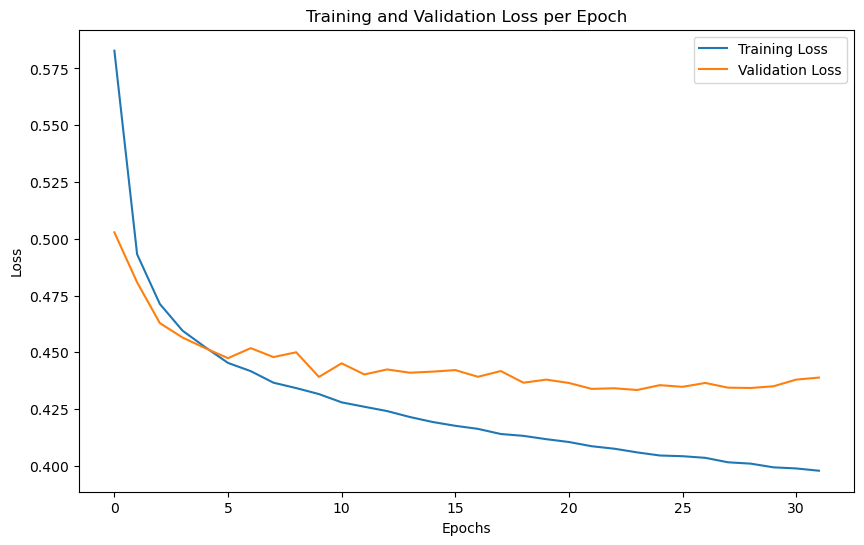

In [33]:
# Get the training and validation graphs

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
model_dnn.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_dnn(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        all_probs.extend(probabilities.numpy())
        all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

In [35]:
num_classes = all_probs.shape[1]
all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))

auc_scores = []
for i in range(num_classes):
    auc_score = roc_auc_score(all_labels_binarized[:, i], all_probs[:, i])
    auc_scores.append(auc_score)

# Compute the macro-average AUC
macro_auc = np.mean(auc_scores)
print("Macro-average AUC:", macro_auc)

Macro-average AUC: 0.9687508807881994


In [36]:
all_labels_flat = (np.arange(all_probs.shape[1]) == all_labels[:, None]).astype(float).ravel()
all_probs_flat = all_probs.ravel()

# Calculate the micro-average AUC
micro_auc = roc_auc_score(all_labels_flat, all_probs_flat)

print("Micro-average AUC:", micro_auc)

Micro-average AUC: 0.9893392895459835


In [37]:
num_classes = all_probs.shape[1]
all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))

class_support = np.sum(all_labels_binarized, axis=0)

weighted_auc = 0
total_instances = len(all_labels)
for i in range(num_classes):
    class_weight = class_support[i] / total_instances
    auc_score = roc_auc_score(all_labels_binarized[:, i], all_probs[:, i])
    weighted_auc += auc_score * class_weight

print("Weighted-average AUC:", weighted_auc)

Weighted-average AUC: 0.9789756510217416


## CNN

In [ ]:
# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD, Adam

In [40]:
### Reshape training and test data for CNN model training
x_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
x_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
input_shape = x_train_cnn.shape[1:]

y_train_cnn = np.array(y_train)
num_classes = len(np.unique(y_train))

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', activation='relu', input_shape=input_shape))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters=20, kernel_size=4, strides=2, padding='same', activation='relu'))
cnn_model.add(Conv1D(filters=3, kernel_size=2, strides=1, padding='same', activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=200, activation='relu'))
cnn_model.add(Dense(units=200, activation='relu'))
cnn_model.add(Dense(units=200, activation='relu'))
cnn_model.add(Dense(units=200, activation='relu'))
cnn_model.add(Dense(units=num_classes, activation='softmax'))

opt = Adam(learning_rate=0.001) 
cnn_model.compile(loss = "sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [ ]:
hist = cnn_model.fit(x_train_cnn, y_train_cnn, epochs=100,
                       batch_size=1000, validation_split=0.2,
                       callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)])

Epoch 1/100
165/165 [==============================] - 4s 24ms/step - loss: 0.4282 - accuracy: 0.8228 - val_loss: 0.4321 - val_accuracy: 0.8204
Epoch 2/100
165/165 [==============================] - 4s 22ms/step - loss: 0.4281 - accuracy: 0.8234 - val_loss: 0.4364 - val_accuracy: 0.8171
Epoch 3/100
165/165 [==============================] - 4s 22ms/step - loss: 0.4274 - accuracy: 0.8238 - val_loss: 0.4370 - val_accuracy: 0.8189
Epoch 4/100
165/165 [==============================] - 4s 22ms/step - loss: 0.4285 - accuracy: 0.8227 - val_loss: 0.4352 - val_accuracy: 0.8175
Epoch 5/100
165/165 [==============================] - 4s 22ms/step - loss: 0.4264 - accuracy: 0.8235 - val_loss: 0.4334 - val_accuracy: 0.8200
Epoch 6/100
165/165 [==============================] - 4s 21ms/step - loss: 0.4271 - accuracy: 0.8234 - val_loss: 0.4366 - val_accuracy: 0.8194
Epoch 7/100
165/165 [==============================] - 4s 22ms/step - loss: 0.4276 - accuracy: 0.8231 - val_loss: 0.4407 - val_accuracy:

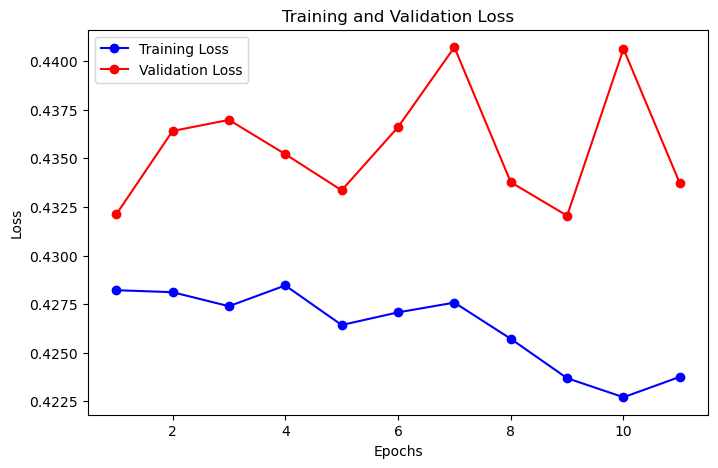

In [ ]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred_probs = cnn_model.predict(X_test)

1611/1611 [==============================] - 4s 3ms/step


In [ ]:
y_pred = np.argmax(y_pred_probs, axis=-1)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
auc_scores = []
for i in range(num_classes):
    y_true_binary = (y_test == i).astype(int)
    y_pred_prob_class = y_pred_probs[:, i]
    auc_score = roc_auc_score(y_true_binary, y_pred_prob_class)
    auc_scores.append(auc_score)

mean_auc = np.mean(auc_scores)
print("Macro Average AUC:", mean_auc)

Macro Average AUC: 0.9695994912919367


In [ ]:
auc_scores = []
class_support = np.bincount(y_test)  
total_instances = len(y_test)
weighted_auc = 0

for i in range(num_classes):
    y_true_binary = (y_test == i).astype(int)
    y_pred_prob_class = y_pred_probs[:, i]

    auc_score = roc_auc_score(y_true_binary, y_pred_prob_class)
    auc_scores.append(auc_score)

    class_weight = class_support[i] / total_instances
    weighted_auc += auc_score * class_weight

print("Weighted-average AUC:", weighted_auc)

Weighted-average AUC: 0.9530596346469594


In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print(f"Macro Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {f1_score:.4f}")

Macro Accuracy: 0.8185
Macro Precision: 0.7521
Macro Recall: 0.4973
Macro F1 Score: 0.5183


In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)

print(f"Micro Accuracy: {accuracy:.4f}")
print(f"Micro Precision: {precision:.4f}")
print(f"Micro Recall: {recall:.4f}")
print(f"Micro F1 Score: {f1_score:.4f}")

Micro Accuracy: 0.8185
Micro Precision: 0.8185
Micro Recall: 0.8185
Micro F1 Score: 0.8185


In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Weighted Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1_score:.4f}")

Weighted Accuracy: 0.8185
Weighted Precision: 0.8148
Weighted Recall: 0.8185
Weighted F1 Score: 0.7948


In [ ]:
num_classes = 6
weighted_TPR, weighted_FPR, weighted_FNR, weighted_TNR = 0, 0, 0, 0
total_instances = np.sum(conf_matrix)

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FNR = FN / (FN + TP) if FN + TP > 0 else 0
    TNR = TN / (TN + FP) if TN + FP > 0 else 0

    class_weight = np.sum(conf_matrix[i, :]) / total_instances

    weighted_TPR += TPR * class_weight
    weighted_FPR += FPR * class_weight
    weighted_FNR += FNR * class_weight
    weighted_TNR += TNR * class_weight

weighted_metrics = {
    "Weighted True Positive Rate (TPR)": round(weighted_TPR, 4),
    "Weighted False Positive Rate (FPR)": round(weighted_FPR, 4),
    "Weighted False Negative Rate (FNR)": round(weighted_FNR, 4),
    "Weighted True Negative Rate (TNR)": round(weighted_TNR, 4)
}

weighted_metrics

{'Weighted True Positive Rate (TPR)': 0.8144,
 'Weighted False Positive Rate (FPR)': 0.047,
 'Weighted False Negative Rate (FNR)': 0.1597,
 'Weighted True Negative Rate (TNR)': 0.9271}

In [ ]:
num_classes = 6
total_TPR, total_FPR, total_FNR, total_TNR = 0, 0, 0, 0

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FNR = FN / (FN + TP) if FN + TP > 0 else 0
    TNR = TN / (TN + FP) if TN + FP > 0 else 0

    total_TPR += TPR
    total_FPR += FPR
    total_FNR += FNR
    total_TNR += TNR

macro_TPR = total_TPR / num_classes
macro_FPR = total_FPR / num_classes
macro_FNR = total_FNR / num_classes
macro_TNR = total_TNR / num_classes

macro_metrics = {
    "Macro True Positive Rate (TPR)": round(macro_TPR, 4),
    "Macro False Positive Rate (FPR)": round(macro_FPR, 4),
    "Macro False Negative Rate (FNR)": round(macro_FNR, 4),
    "Macro True Negative Rate (TNR)": round(macro_TNR, 4)
}

macro_metrics

{'Macro True Positive Rate (TPR)': 0.7006,
 'Macro False Positive Rate (FPR)': 0.0377,
 'Macro False Negative Rate (FNR)': 0.2994,
 'Macro True Negative Rate (TNR)': 0.9623}

In [ ]:
num_classes = 6
total_TP, total_FP, total_FN, total_TN = 0, 0, 0, 0

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    total_TP += TP
    total_FP += FP
    total_FN += FN
    total_TN += TN

micro_TPR = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
micro_FPR = total_FP / (total_FP + total_TN) if total_FP + total_TN > 0 else 0
micro_FNR = total_FN / (total_FN + total_TP) if total_FN + total_TP > 0 else 0
micro_TNR = total_TN / (total_TN + total_FP) if total_TN + total_FP > 0 else 0

micro_metrics = {
    "Micro True Positive Rate (TPR)": round(micro_TPR, 4),
    "Micro False Positive Rate (FPR)": round(micro_FPR, 4),
    "Micro False Negative Rate (FNR)": round(micro_FNR, 4),
    "Micro True Negative Rate (TNR)": round(micro_TNR, 4)
}

micro_metrics

{'Micro True Positive Rate (TPR)': 0.8361,
 'Micro False Positive Rate (FPR)': 0.0356,
 'Micro False Negative Rate (FNR)': 0.1639,
 'Micro True Negative Rate (TNR)': 0.9644}

## RNN

In [ ]:
num_features = 61
num_classes = 10  # Number of classes

class RNNTabularMulticlass(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNTabularMulticlass, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

In [ ]:
input_size = num_features
hidden_size = 100
output_size = num_classes  # Multiclass classification
model_rnn = RNNTabularMulticlass(input_size, hidden_size, output_size)

early_stopping = EarlyStopping(patience=5, delta=0.0001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)

epochs = 100
training_losses = []
validation_losses = [] 

for epoch in range(epochs):
    model_rnn.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model_rnn(inputs.unsqueeze(1))  # Reshape input
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Validation
    model_rnn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model_rnn(inputs.unsqueeze(1))  # Reshape input
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Implement early stopping
    if early_stopping is None:
        early_stopping = EarlyStopping(patience=5, delta=0.0001)
    
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print('Finished Training')


Epoch [1/100], Training Loss: 0.6053, Validation Loss: 0.5278
Epoch [2/100], Training Loss: 0.5120, Validation Loss: 0.4963
Epoch [3/100], Training Loss: 0.4855, Validation Loss: 0.4752
Epoch [4/100], Training Loss: 0.4695, Validation Loss: 0.4658
Epoch [5/100], Training Loss: 0.4595, Validation Loss: 0.4620
Epoch [6/100], Training Loss: 0.4531, Validation Loss: 0.4572
Epoch [7/100], Training Loss: 0.4481, Validation Loss: 0.4538
Epoch [8/100], Training Loss: 0.4443, Validation Loss: 0.4483
Epoch [9/100], Training Loss: 0.4400, Validation Loss: 0.4453
Epoch [10/100], Training Loss: 0.4373, Validation Loss: 0.4419
Epoch [11/100], Training Loss: 0.4348, Validation Loss: 0.4404
Epoch [12/100], Training Loss: 0.4320, Validation Loss: 0.4391
Epoch [13/100], Training Loss: 0.4297, Validation Loss: 0.4381
Epoch [14/100], Training Loss: 0.4281, Validation Loss: 0.4376
Epoch [15/100], Training Loss: 0.4263, Validation Loss: 0.4359
Epoch [16/100], Training Loss: 0.4244, Validation Loss: 0.4372
E

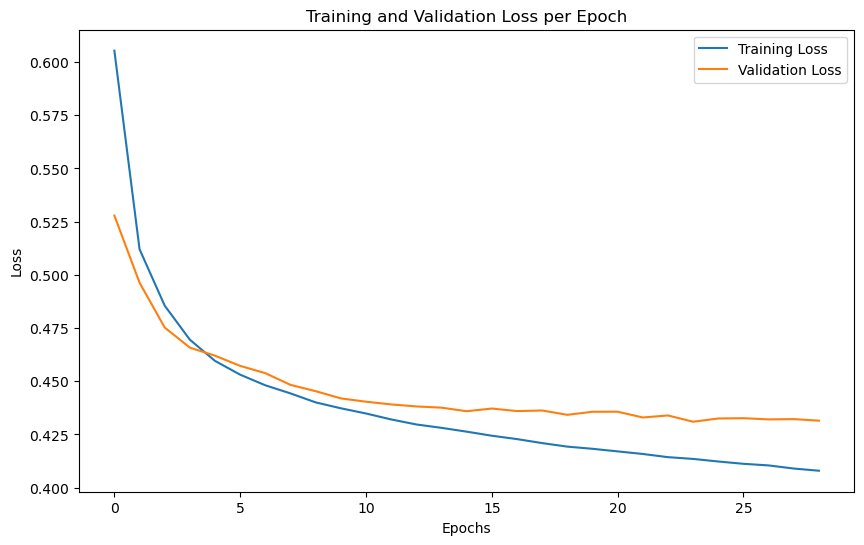

In [ ]:
# Get the training and validation graphs

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluations
model_rnn.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    test_outputs = model_rnn(X_test_tensor.unsqueeze(1))
    predicted_probs = torch.softmax(test_outputs, dim=1).numpy()
    predicted_labels = torch.argmax(test_outputs.squeeze(), dim=1).numpy()

conf_matrix = confusion_matrix(y_test_tensor.numpy(), predicted_labels)

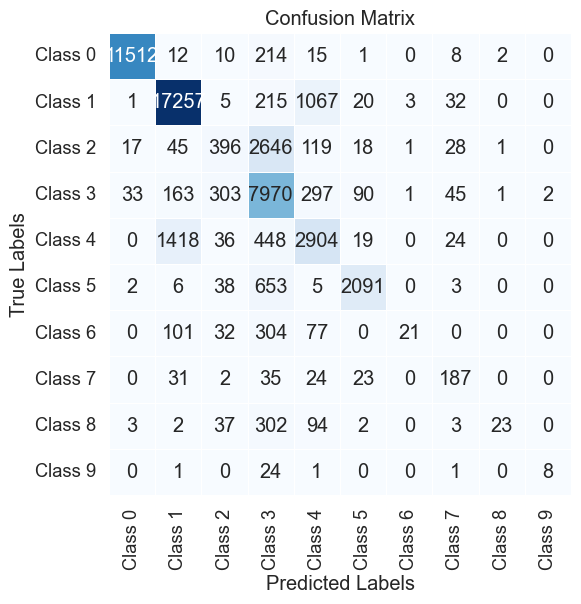

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, square=True, cbar=False,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), predicted_labels, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Macro Precision: {precision:.4f}')
print(f'Macro Recall: {recall:.4f}')
print(f'Macro F1 Score: {f1:.4f}')

Accuracy: 0.8221
Macro Precision: 0.7564
Macro Recall: 0.5204
Macro F1 Score: 0.5384


In [ ]:
accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), predicted_labels, average='micro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Micro Precision: {precision:.4f}')
print(f'Micro Recall: {recall:.4f}')
print(f'Micro F1 Score: {f1:.4f}')

Accuracy: 0.8221
Micro Precision: 0.8221
Micro Recall: 0.8221
Micro F1 Score: 0.8221


In [ ]:
accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Macro Precision: {precision:.4f}')
print(f'Macro Recall: {recall:.4f}')
print(f'Macro F1 Score: {f1:.4f}')

Accuracy: 0.8221
Macro Precision: 0.8208
Macro Recall: 0.8221
Macro F1 Score: 0.8033


In [ ]:
roc_auc = roc_auc_score(y_test_tensor.numpy(), predicted_probs, average='macro', multi_class='ovr')
print(roc_auc)

0.9699844602443871


In [ ]:
roc_auc = roc_auc_score(y_test_tensor.numpy(), predicted_probs, average='micro', multi_class='ovr')
print(roc_auc)

0.9894443989004379


In [ ]:
roc_auc = roc_auc_score(y_test_tensor.numpy(), predicted_probs, average='weighted', multi_class='ovr')
print(roc_auc)

0.9789589774361417


In [ ]:
class_labels = list(range(num_classes))
tpr = []
fpr = []
tnr = []
fnr = []

for i in class_labels:
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (fp + conf_matrix[i, :].sum())
    fn = conf_matrix[i, :].sum() - tp

    tpr_i = tp / (tp + fn)
    fpr_i = fp / (fp + tn)
    tnr_i = tn / (tn + fp)  
    fnr_i = fn / (fn + tp)  

    tpr.append(tpr_i)
    fpr.append(fpr_i)
    tnr.append(tnr_i)
    fnr.append(fnr_i)

macro_avg_tpr = sum(tpr) / len(tpr)
macro_avg_fpr = sum(fpr) / len(fpr)
macro_avg_tnr = sum(tnr) / len(tnr)
macro_avg_fnr = sum(fnr) / len(fnr)

print(f'Macro-Average TPR: {macro_avg_tpr:.4f}')
print(f'Macro-Average FPR: {macro_avg_fpr:.4f}')
print(f'Macro-Average TNR: {macro_avg_tnr:.4f}')
print(f'Macro-Average FNR: {macro_avg_fnr:.4f}')

Macro-Average TPR: 0.5204
Macro-Average FPR: 0.0222
Macro-Average TNR: 0.9778
Macro-Average FNR: 0.4796


In [ ]:
class_labels = list(range(num_classes))

tp_total = 0
fp_total = 0
tn_total = 0
fn_total = 0

for i in class_labels:
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (fp + conf_matrix[i, :].sum())
    fn = conf_matrix[i, :].sum() - tp

    # Aggregate counts
    tp_total += tp
    fp_total += fp
    tn_total += tn
    fn_total += fn

# Compute micro-average rates
micro_avg_tpr = tp_total / (tp_total + fn_total)
micro_avg_fpr = fp_total / (fp_total + tn_total)
micro_avg_tnr = tn_total / (tn_total + fp_total)
micro_avg_fnr = fn_total / (fn_total + tp_total)

print(f'Micro-Average TPR: {micro_avg_tpr:.4f}')
print(f'Micro-Average FPR: {micro_avg_fpr:.4f}')
print(f'Micro-Average TNR: {micro_avg_tnr:.4f}')
print(f'Micro-Average FNR: {micro_avg_fnr:.4f}')

Micro-Average TPR: 0.8221
Micro-Average FPR: 0.0198
Micro-Average TNR: 0.9802
Micro-Average FNR: 0.1779


In [ ]:
class_labels = list(range(num_classes))

weighted_sum_tpr = 0
weighted_sum_fpr = 0
weighted_sum_tnr = 0
weighted_sum_fnr = 0

total_instances = conf_matrix.sum()

for i in class_labels:
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (fp + conf_matrix[i, :].sum())
    fn = conf_matrix[i, :].sum() - tp

    tpr_i = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr_i = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr_i = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr_i = fn / (fn + tp) if (fn + tp) > 0 else 0

    class_weight = (tp + fn) / total_instances

    weighted_sum_tpr += tpr_i * class_weight
    weighted_sum_fpr += fpr_i * class_weight
    weighted_sum_tnr += tnr_i * class_weight
    weighted_sum_fnr += fnr_i * class_weight

print(f'Weighted-Average TPR: {weighted_sum_tpr:.4f}')
print(f'Weighted-Average FPR: {weighted_sum_fpr:.4f}')
print(f'Weighted-Average TNR: {weighted_sum_tnr:.4f}')
print(f'Weighted-Average FNR: {weighted_sum_fnr:.4f}')

Weighted-Average TPR: 0.8221
Weighted-Average FPR: 0.0437
Weighted-Average TNR: 0.9563
Weighted-Average FNR: 0.1779
